In [110]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from pycox.datasets import gbsg
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [111]:
df_train = gbsg.read_df()
df_train.columns = ["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec", "duration", "event"]
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)


In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_train[["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec"]] = scaler.fit_transform(df_train[["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec"]])
df_val[["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec"]] = scaler.transform(df_val[["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec"]])
df_test[["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec"]] = scaler.transform(df_test[["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec"]])


In [113]:
class deepsurv() :
    def __init__(self,df,duration_col_name,event_col_name,hidden_dim,drop_out_rate,lr,l2=0) :
        # for later
        self.table = None
        self.survival0 = None
        self.drop_out_rate = drop_out_rate
        
        # Data Set related
        self.df = df
        self.duration_col_name = duration_col_name
        self.event_col_name = event_col_name

        
        # model(nn) structure related
        self.hidden_dim = hidden_dim
        self.l2=l2
        
        # optimizer & learning rate
        self.lr = lr
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        

    ## Spliting X(covariates) & T(time,duration) & E(event indicator) from Original Dataset
    ## Changing DataType to float32 -> Tensorflowable
    
    def fit_data(self,df=None) :
        if df is None : 
            df = self.df
            
        # sorting data - descending by duration
        df = df.sort_values(by=self.duration_col_name,ascending=False)
        
        # Split Data into X : covariates, T : duration, E: event
        X = df.drop([self.duration_col_name,self.event_col_name],axis=1)
        T = df[self.duration_col_name]
        E = df[self.event_col_name]
        
        # dtype to float32
        self.X = tf.cast(X,dtype=tf.float32)
        self.T = tf.cast(T,dtype=tf.float32)
        self.E = tf.cast(E,dtype=tf.float32)
        
        # k = number of input variables
        self.k = self.X.shape[1]
        
        return self.X, self.T, self.E

                
    ## fit_data와 동일. validation set or test set 만들 때 사용        
    def transform_data(self, df) :
        df = df.sort_values(by=self.duration_col_name,ascending=False)
        
        X = df.drop([self.duration_col_name,self.event_col_name],axis=1)
        T = df[self.duration_col_name]
        E = df[self.event_col_name]
    
        X = tf.cast(X,dtype=tf.float32)
        T = tf.cast(T,dtype=tf.float32)
        E = tf.cast(E,dtype=tf.float32)
        
        return X,T,E
            
    
    ## build model - nn model with hidden layers
    def fit_model(self,hidden_dim=None,l1=None,drop_out_rate = None ,l2=None) :
        if hidden_dim is None : 
            hidden_dim = self.hidden_dim
        if drop_out_rate is None :
            drop_out_rate = self.drop_out_rate
        
        nn = tf.keras.models.Sequential()
        nn.add(tf.keras.Input(shape=(self.k,)))
        for dims in hidden_dim :
            nn.add(tf.keras.layers.Dense(dims,activation = 'sigmoid')) 
            nn.add(tf.keras.layers.Dropout(rate=drop_out_rate))
        nn.add(tf.keras.layers.Dense(1,use_bias=False)) # no activation function applied at the end
        
        self.model = nn
    
    # Training Related
    ## -log likelihood(theta) 
    def negative_log_likelihood(self, model=None, X=None, T=None, E=None) :
        if model is None :
            model=self.model 
        if X is None : 
            X=self.X 
        if T is None : 
            T=self.T
        if E is None : 
            E=self.E
        
        g = model(X)
        log_h_cumsum = tf.math.log(tf.cumsum(tf.exp(g)))
        E = tf.reshape(E,[-1,1])
        
        return -tf.math.divide(tf.math.reduce_sum(tf.multiply(E,tf.subtract(g,log_h_cumsum))), tf.math.reduce_sum(E))
    
    ## L2 Regularization 
    def l2_regularization(self, model=None, l2=None) :
        if model is None :
            model = self.model
        if l2 is None :
            l2 = self.l2
                
        return tf.add_n([ tf.nn.l2_loss(v) for v in model.trainable_variables ]) * l2

    ## fit(training) - GD type optimization / returns best model(best validation_loss)
    ## if no validation dataset provided, validation set == train set
    def fit(self,model=None, X=None, T=None, E=None,X_val=None, T_val=None, E_val=None,
            l2=None,epoch=10,verbose=False,plot=True) :
        if model is None :
            model=self.model 
        if X is None : 
            X=self.X 
        if T is None : 
            T=self.T
        if E is None : 
            E=self.E
        if X_val is None : 
            X_val=self.X 
        if T_val is None : 
            T_val=self.T
        if E is None : 
            E_val=self.E

        if l2 is None :
            l2 = self.l2

        best_model = model
        best_loss = self.negative_log_likelihood(model=model, X=X_val,T=T_val,E=E_val).numpy() + self.l2_regularization(model,l2).numpy()
        
        train_loss_l = [] ; val_loss_l = []
        for i in range(epoch) :
            with tf.GradientTape() as tape:
                loss_value = self.negative_log_likelihood(model,X,T,E) + self.l2_regularization(model,l2)

                current_gradient = tape.gradient(loss_value, model.trainable_variables)
                
                self.optimizer.apply_gradients(zip(current_gradient,model.trainable_variables))
                
                current_train_loss = self.negative_log_likelihood(model=self.model, X=X,T=T,E=E).numpy() + self.l2_regularization(model,l2).numpy()
                current_val_loss = self.negative_log_likelihood(model=model, X=X_val,T=T_val,E=E_val).numpy() + self.l2_regularization(model,l2).numpy()
                
                train_loss_l.append(current_train_loss)
                val_loss_l.append(current_val_loss)
                
            if verbose :
                print("%s / %s epoch :" %(i+1,epoch))
                print("train_loss: %s, val_loss: %s" %(current_train_loss,current_val_loss))

            if  current_val_loss < best_loss :
                best_model = model
                best_loss = self.negative_log_likelihood(model=self.model, X=X_val,T=T_val,E=E_val).numpy() + self.l2_regularization(model,l2).numpy()
                best_epoch = i
                
        self.model = best_model
        self.train_loss = self.negative_log_likelihood(model=self.model, X=X,T=T,E=E).numpy() + self.l2_regularization(model,l2).numpy()
        self.val_loss = self.negative_log_likelihood(model=self.model, X=X_val,T=T_val,E=E_val).numpy() + self.l2_regularization(model,l2).numpy()
        
        if plot :
            plt.plot(range(epoch),train_loss_l)
            plt.plot(range(epoch),val_loss_l)
            plt.plot(best_epoch,best_loss,'ro') 
            
        #### baseline hazard function!!!!!
                
    def predict_partial_hazard(self,model=None,X=None) :
        if model is None :
            model = self.model
            
        if X is None :
            X = self.X
        
        return np.exp(model.predict(X))
    
    def fit_table(self,model=None,X=None, T=None, E=None, plot=True, save_table=True) :
        if model is None :
            model = self.model

        if X is None :
            X = self.X

        if T is None :
            T = self.T
        
        if E is None :
            E = self.E
            
        partial_hazard = self.predict_partial_hazard(model,X)

        # Dataframe화
        Table = pd.DataFrame.from_dict({'T':T.numpy().flatten(),'E':E.numpy().flatten(),'partial_hazard':partial_hazard.flatten()})
        
        # 시점별 partial hazard(exp(g(x|theta)) / Event 발생수 모음
        Table = Table.groupby('T').agg({'partial_hazard': 'sum', 'E': 'sum'}).sort_index(ascending=False) 
        
        #  
        Table = Table.assign(sum_hazard_at_risk=lambda x: x['partial_hazard'].cumsum())
        Table = Table.assign(h0=lambda x: x['E']/x['sum_hazard_at_risk']).fillna(0.)
        Table = Table.assign(H0=np.flip(np.cumsum(np.flip(Table['h0']))))
        Table = Table.assign(S0=np.exp(-Table['H0']))
        Table = Table[Table.E != 0] 
        Table = Table.reset_index()
    
        if plot :
            plt.subplot(1,2,1)
            plt.plot(Table['T'],Table['H0'])
            plt.title('Cumulative Hazard')
            
            plt.subplot(1,2,2)
            plt.plot(Table['T'],Table['S0'])
            plt.title('Cumulative Survival')
        
        if save_table : 
            self.table = Table
            
        return Table
    
    def fit_baseline_Survival(self,Table=None,t_0=0, t_max=None, s_0=1, s_max=0) :
        if Table is None :
            if self.table is None :
                Table = self.fit_table(save_table=False)
            else :
                Table = self.table
        
        if t_max is None :
            t_max = 10*np.max(self.T)
        
        T_fit=Table['T'].append(pd.Series([t_0,t_max])).reset_index(drop=True)
        S_fit=Table['S0'].append(pd.Series([s_0,s_max])).reset_index(drop=True)
        
        baseline_survival = interp1d(T_fit,S_fit,kind = 'linear')
        
        self.baseline_survival = baseline_survival
        return baseline_survival
    
    def predict_survival(self,X=None, T=None, E=None, model=None, baseline_survival=None) : 
        if X is None :
            X = self.X
        if T is None :
            T = self.T
        if E is None : 
            E = self.E
        if model is None :
            model = self.model
        if baseline_survival is None :
            if self.baseline_survival is None : 
                baseline_survival = fit_baseline_Survival()
            else :
                baseline_survival = self.baseline_survival
            
        g = np.array(model(X)).flatten() #output from model(partial_hazard)
        S0 = np.array(baseline_survival(T)) # baseline survival
        S = np.power(S0,np.exp(g))
        
        return S
            


적용 순서
1. fit_data # prep (필수)
2. fit_model # model structure specification (필수)
3. fit # actual training (필수)
3. fit_table # To compute baseline Survival
4. fit_baseline_survival # compute S0
5. predict_survival # compute individual survival probability given $X_i, T_i$, $T_i$ : event time 

---
6. predict

In [121]:
d = deepsurv(df=df_train,duration_col_name='duration',event_col_name='event',
             hidden_dim=[20],drop_out_rate=0.2,lr=0.001,l2=1)

d.fit_data()
X_train, T_train, E_train = d.transform_data(df_train) 
X_val, T_val, E_val = d.transform_data(df_val)
X_test, T_test, E_test = d.transform_data(df_test)

d.fit_model()
d.model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 20)                160       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 20        
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


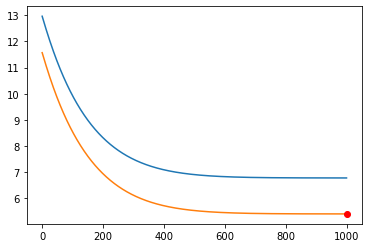

In [122]:
d.fit(X_val = X_val, T_val = T_val, E_val = E_val, epoch=1000)

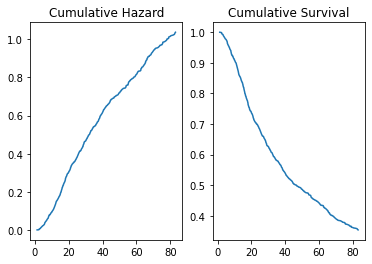

In [124]:
d.fit_table()
d.fit_baseline_Survival()

### 성능 비교

In [125]:
from lifelines.utils import concordance_index
print(concordance_index(d.T, -d.predict_partial_hazard(model = None,X = X_train), d.E))
print(concordance_index(T_test, -d.predict_partial_hazard(model = None,X = X_test), E_test))


0.6221581625657238
0.6326706147772138


In [126]:
from lifelines import CoxPHFitter
cph_breslow = CoxPHFitter(baseline_estimation_method="breslow", n_baseline_knots=5)
cph_breslow.fit(df = d.df, duration_col = 'duration', event_col = 'event', show_progress = False)

print(concordance_index(d.T, -cph_breslow.predict_partial_hazard(d.X.numpy()), d.E))
print(concordance_index(T_val, -cph_breslow.predict_partial_hazard(X_val.numpy()), E_val))

0.6608504656249959
0.6481871569002936


### Try with different Dataset

#### rotterdam

##### Data Loading & Preprocessing

In [283]:
rotterdam = pd.read_csv("G:/내 드라이브/papers_related/data/rotterdam.csv")
rotterdam = rotterdam[['age','meno','size','grade','nodes','pgr','er','hormon','chemo','rtime','recur','dtime','death']]
rotterdam = rotterdam.sort_values(by='dtime',ascending=False)

rotterdam.head()

,age,meno,size,grade,nodes,pgr,er,hormon,chemo,rtime,recur,dtime,death
758,49,1,20-50,2,0,0,0,0,0,7042.999986,0,7042.999986,0
18,51,0,20-50,3,1,14,0,0,0,7027.000049,0,7027.000049,0
1373,45,0,<=20,3,0,256,0,0,0,2569.999991,1,6885.999965,0
569,37,0,<=20,3,0,85,20,0,0,6728.999944,0,6728.999944,0
2695,59,1,20-50,2,0,0,11,0,0,5312.999941,1,6429.999901,0


In [286]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Train-Validation-Test set split
X_1 = rotterdam[['age','meno','size','grade','nodes','pgr','er','hormon','chemo','recur','dtime']]
e_1 = rotterdam[['death']]

X_train, X_test, e_train, e_test = train_test_split(X_1,e_1, test_size=0.2,stratify=e_1)
X_train, X_val, e_train, e_val = train_test_split(X_train,e_train, test_size=0.2,stratify=e_train)

# X, T, E split
t_train = X_train['dtime']
X_train = X_train[['age','meno','size','grade','nodes','pgr','er','hormon','chemo','recur']]

t_test = X_test['dtime']
X_test = X_test[['age','meno','size','grade','nodes','pgr','er','hormon','chemo','recur']]

t_val = X_val['dtime']
X_val = X_val[['age','meno','size','grade','nodes','pgr','er','hormon','chemo','recur']]

# one hot encoding and scaling
cat_v = ['meno','size','grade','hormon','chemo','recur']
num_v = ['age','nodes','pgr','er']

ohe = OneHotEncoder()
ohe.fit(X_train[cat_v])

scaler = StandardScaler()
scaler.fit(X_train[num_v])

X_train = np.concatenate((ohe.transform(X_train[cat_v]).toarray(),scaler.transform(X_train[num_v])), axis=1, out=None)
X_test = np.concatenate((ohe.transform(X_test[cat_v]).toarray(),scaler.transform(X_test[num_v])), axis=1, out=None)
X_val = np.concatenate((ohe.transform(X_val[cat_v]).toarray(),scaler.transform(X_val[num_v])), axis=1, out=None)

# Back to df form to match deepsurv class
# col 0 : time / col 1 : event / col rest : X
train_df = pd.DataFrame(np.concatenate((np.array(t_train).reshape(-1,1),e_train,X_train),axis=1))
test_df = pd.DataFrame(np.concatenate((np.array(t_test).reshape(-1,1),e_test,X_test),axis=1))
val_df = pd.DataFrame(np.concatenate((np.array(t_val).reshape(-1,1),e_val,X_val),axis=1))

In [355]:
d = deepsurv(df=train_df,duration_col_name=0,event_col_name=1,
             hidden_dim=[19,16],drop_out_rate=0.5,lr=0.001,l2=0.01)

d.fit_data()

X_train, T_train, E_train = d.transform_data(train_df) 
X_val, T_val, E_val = d.transform_data(val_df)
X_test, T_test, E_test = d.transform_data(test_df)

d.fit_model()
d.model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 19)                342       
_________________________________________________________________
dropout_31 (Dropout)         (None, 19)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 16)                320       
_________________________________________________________________
dropout_32 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 16        
Total params: 678
Trainable params: 678
Non-trainable params: 0
_________________________________________________________________


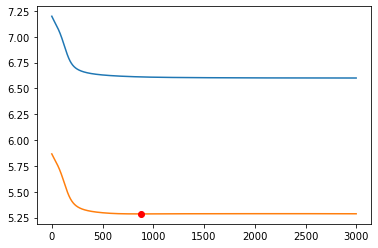

In [356]:
d.fit(X_val = X_val, T_val = T_val, E_val = E_val, epoch=3000)

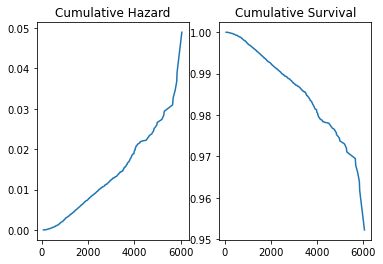

In [357]:
d.fit_table()
d.fit_baseline_Survival()

In [358]:
from lifelines.utils import concordance_index
print(concordance_index(d.T, -d.predict_partial_hazard(model = None,X = X_train), d.E))
print(concordance_index(T_test, -d.predict_partial_hazard(model = None,X = X_test), E_test))

0.8040863730375549
0.7794607206198962


In [350]:
from lifelines import CoxPHFitter
cph_breslow = CoxPHFitter(baseline_estimation_method="breslow",penalizer=0.1)
cph_breslow.fit(df = d.df, duration_col = 0, event_col = 1, show_progress = False)

print(concordance_index(d.T, -cph_breslow.predict_partial_hazard(d.X.numpy()), d.E))
print(concordance_index(T_val, -cph_breslow.predict_partial_hazard(X_val.numpy()), E_val))

0.7848074178398445
0.7906174949536621


,age,meno,size,grade,nodes,pgr,er,hormon,chemo,rtime,recur,dtime,death
0,74,1,<=20,3,0,35,291,0,0,1798.999948,0,1798.999948,0
1,79,1,20-50,3,0,36,611,0,0,2828.000021,0,2828.000021,0
2,44,0,<=20,2,0,138,0,0,0,6011.999804,0,6011.999804,0
3,70,1,20-50,3,0,0,12,0,0,2623.999895,0,2623.999895,0
4,75,1,<=20,3,0,260,409,0,0,4914.999997,0,4914.999997,0
